# Relatório EP2 - Programação Concorrente e Paralela

**Alunos**: 
- Erick Rodrigues de Santana, NUSP: 11222008
- Francisco Eugênio Wernke, NUSP: 11221870
- Thiago Guerrero Balera, NUSP: 11275297
- Vinicius Pereira Ximenes Frota, NUSP: 11221967

**Professor**: Alfredo Goldman

**Monitores**: Elisa Silva e Luciana Marques

O relatório a seguir foi elaborado com base nas instruções do EP2 da Matéria MAC0219 - Programação Concorrente e Paralela.

## Executando o programa
Para executar o programa *mandelbrot* nas versões com MPI (Sequencial, OpenMP e Pthreads), adicionamos um argumento extra para definir o número de processos a serem criados (num_processes). Além disto, nas versões internamente paralelizadas, ainda existe o argumento de quantas threads serão criadas (num_threads). Antes de executar os comandos, é necessário gerar os binários desta forma:

```bash
cd src
make
```

Agora, pode-se executar as três formas do mandelbrot com MPI da seguinte forma:

```bash
mpirun -np <num_processes> mandelbrot_mpi
mpirun -np <num_processes> mandelbrot_mpi_omp <num_threads>
mpirun -np <num_processes> mandelbrot_mpi_pth <num_threads>
```

# Parte 1 - Estimativa dos melhores parâmetros

## Observações

Todas as execuções do programa foram feitas na Rede Linux usando 15 medições para cada tipo de execução.

In [52]:
# Bibliotecas importadas
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt

# Leitura de dados CSV
csv = pd.read_csv("../measurements/data.csv")
print(csv)

        tipo  processos  threads         tempo
0        mpi          1        1  24237.120152
1        mpi          1        1  24395.095348
2        mpi          1        1  24355.067730
3        mpi          1        1  24333.413601
4        mpi          1        1  24350.424290
..       ...        ...      ...           ...
970  mpi_omp         16       32   1168.375492
971  mpi_omp         16       32   1420.077801
972  mpi_omp         16       32   1414.572239
973  mpi_omp         16       32   1179.508924
974  mpi_omp         16       32   1176.087618

[975 rows x 4 columns]


## Organização dos dados

Para agrupar os dados coletados usamos a estrutura de dados de dicionário. A estrutura pode ser entendida assim:
```json
{
    mpi: [
        1 processo: Pair<Média, Intervalo de confiança>,
        2 processos: Pair<Média, Intervalo de confiança>,
        ...
        16 processos: Pair<Média, Intervalo de confiança>
    ],
    mpi_pth: {
        1 thread: [
            1 processo: Pair<Média, Intervalo de confiança>,
            2 processos: Pair<Média, Intervalo de confiança>,
            4 processos: Pair<Média, Intervalo de confiança>,
            ...
            16 processos: Pair<Média, Intervalo de confiança>
        ],
        2 threads: [
            ...Mesmo que para 1 processo
        ],
        ...
        32 threads: [
            ...Mesmo que para 1 processo
        ],
    },
    mpi_omp: { ...Mesmo que mpi_pth }
}
```
Onde *seqio* representa o tempo total e *seq* representa o tempo sem as operações de I/O e gerenciamento de memória da versão sequencial.

Como o intervalo de confiança é simétrico em torno da média, só armazenamos os limiares.
<!--  apagar depois-->

In [53]:
data = {"seq": (0,0), "pth" : [], "omp" : [], "mpi" : [], "mpi_pth" : dict(), "mpi_omp" : dict()}

threads = [2**i for i in range(6)]
tipos = ["mpi", "mpi_pth", "mpi_omp"]



## Intervalo de confiança

Para 95% de nível de confiança e n-1 (14) graus de liberdade, obtemos pela tabela da t-student o valor 2.1448 para z.


In [54]:
def confidence_interval(vector, mean):
    z = 2.1448
    n = len(vector)
    sigma = 0
    for i in vector:
        sigma += (i - mean)**2;

    sigma /= n-1;
    sigma = sqrt(sigma);
    return z * sigma/sqrt(n);

In [55]:
for i in range(5):
    vector = csv["tempo"][i*15:(i+1)*15]
    mean = sum(vector)/15
    pair = (mean, confidence_interval(vector, mean))
    data["mpi"].append(pair)
    
for tipo in tipos[1:]:
    for thread in threads:
        data[tipo][thread] = []
        
        filtered = csv[csv["tipo"] == tipo]
        filtered = filtered[filtered["threads"] == thread]
        filtered = list(filtered["tempo"])
        for i in range(5):
            vector = filtered[i*15:(i+1)*15]
            mean = sum(vector)/15
            pair = (mean, confidence_interval(vector, mean))
            data[tipo][thread].append(pair)
        


In [56]:
data

{'seq': (0, 0),
 'pth': [],
 'omp': [],
 'mpi': [(24340.326674733333, 74.62604191774881),
  (13094.284884066667, 70.34995500144774),
  (6841.701110133333, 82.62360100746305),
  (3642.6725706666666, 81.44316272438556),
  (1995.2112674666666, 75.7045419957342)],
 'mpi_pth': {1: [(24348.083607266668, 75.55687711742361),
   (13026.887925466668, 82.91086932891363),
   (6876.0444322, 77.66861966519785),
   (3671.4347998666663, 82.15912998171454),
   (2089.476156333333, 75.59466282954124)],
  2: [(16151.4556568, 83.0896209821448),
   (8527.199252466668, 81.76203936024427),
   (3702.7171612, 69.06500455247945),
   (2113.564459466667, 93.30767875089816),
   (1407.1128208666667, 66.9709474311023)],
  4: [(15695.39265626667, 105.42695854439043),
   (8428.322060800001, 86.65056504731804),
   (2036.5857918, 81.91292538976612),
   (1411.9818052, 59.451005295984274),
   (1305.0003370000002, 54.0790383332224)],
  8: [(15605.376656666665, 96.15638124431102),
   (8367.128753666668, 85.89284605066572),
 

## Visualização dos resultados

Para visualizar os resultados, plotamos um gráfico para cada tipo de programa em cada tipo de imagem e, nas versões paralelizáveis, para cada número de *threads* também.

Por motivos de melhor visualização dos resultados, optamos por exibir os eixos em escala logarítimica com base 2. O eixo x representa os expoentes do tamanho de entrada e o eixo y representa o log2 da média do tempo de execução em milissegundos.

In [26]:
# Definição do eixo x
x = [2**i for i in range(5)]

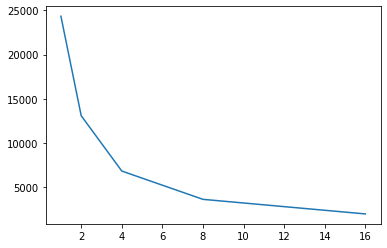

In [29]:
# Coleta dos dados necessários para cada plot
y_mpi = [i[0] for i in data["mpi"]]
confidence_mpi = [i[1] for i in data["mpi"]]

plt.plot(x_mpi, y_mpi)

In [ ]:
# Plota os 4 gráficos de cada tipo de programa para cada imagem usando o número de threads fornecido


## Resultados

### Como e por que as três versões do programa se comportam com a variação:


* **Do tamanho da entrada?**
    
    O tempo gasto é proporcional ao tamanho da entrada independentemente da versão. Além disto, podemos ver que todos os gráficos possuem o mesmo formato mas com valores diferentes. Isto ocorre pois, em qualquer método escolhido para fazer a computação, um aumento no tamanho da entrada implica em mais trabalho a ser realizado e todos os métodos reagem de forma similar à este aumento. 
        
        
* **Das regiões do Conjunto de Mandelbrot?**
    
     O tempo gasto na figura *full* é relativamente menor do que o tempo gasto nas outras figuras na versão sequencial. Isto ocorre pois, em relação ao limitante *escape_radius_squared* definido, os pixels da figura *full* divergem em menos iterações do que os pixels das outras figuras, fazendo com que o programa execute mais rapidamente. Nas versões paralelizadas, a diferença de tempo gasto entre as figuras é relativa à quantidade de threads.
        
        
* **Do número de threads?**
    
    Conforme o número de threads aumenta, conseguimos observar, para tamanhos cada vez maiores de entrada, uma redução do tempo cada vez mais proporcional ao número de threads. Isto ocorre pois, quando começamos a ter tamanhos de entrada cada vez maiores, o benefício do uso das threads e da divisão do trabalho acabam superando o seu custo de criação.
    
    Além disso, observamos que, nas versões paralelizadas, quanto maior o número de threads, menor é a diferença de tempo gasto entre as imagens. Isto ocorre pois quanto mais dividimos a imagem em diferentes seções, mais homogênea fica a distribuição dos pixels que demoram muitas iterações para divergir e, portanto, as seções demoram relativamente o mesmo tempo. Assim o programa executa em menos tempo, pois mais threads executarão e terminarão juntas.
 
### Qual o impacto das operações de I/O e alocação de memória no tempo de execução?

Analisando o código, podemos perceber que as operações de I/O e alocação de memória gastam tempo proporcional a t^2 (O(t^2)), onde t é o tamanho da entrada. Podemos notar, então, que a influência dessas operações no tempo é relativa entre os pontos e, para valores de entrada pequenos, o tempo de processamento é ínfimo enquanto a maior parte do tempo gasto pela execução do programa é realizando essas operações.

# Parte 2 